# MCP-HaloTag testing: Bin Average Fit

## Data import

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from transcription_pipeline import preprocessing_pipeline
RBSPWM_dataset1 = "test_data/2024-02-26/Halo-RBSPWM_embryo01"
RBSPWM_dataset2 = "test_data/2024-02-26/Halo-RBSPWM_embryo02"

RBSPWM_dataset3 = "test_data/2024-05-07/Halo552-RBSPWM_embryo01" # 1024x256, time res 4.2 seconds
RBSPWM_dataset4 = "test_data/2024-05-07/Halo552-RBSPWM_embryo02" # 800x300 

RBSPWM_dataset5 = "test_data/2024-05-09/Halo552-RBSPWM_embryo01" # 40x magnification

InputOutput_embryo1 = "test_data/InputOutput_MCPHaloTag/2024-03-07/embryo1"
InputOutput_embryo2 = "test_data/InputOutput_MCPHaloTag/2024-03-07/embryo2"

test_dataset_name = RBSPWM_dataset5

`JAVA_HOME` environment variable set to /mnt/Data1/Josh/miniforge3/envs/transcription_pipeline


In [2]:
# ## Import from scratch
# dataset = preprocessing_pipeline.DataImport(
#     name_folder=test_dataset_name,
#     trim_series=True,
#     working_storage_mode='zarr',
#     # import_previous=True, 
# )
# dataset.save()

In [3]:
## Load from zarr
dataset = preprocessing_pipeline.DataImport(
    name_folder=test_dataset_name,
    trim_series=True,
    # working_storage_mode='zarr',
    import_previous=True, 
)

### Starting a Dask Client for parallelization

In [4]:
from dask.distributed import LocalCluster, Client

try:
    cluster = LocalCluster(
        host="localhost",
        scheduler_port=37763,
        threads_per_worker=1,
        n_workers=14,
        memory_limit="6GB",
    )
    
    client = Client(cluster)
except:
    print("Cluster already running")
    client = Client('localhost:37763')

print(client)

/mnt/Data1/Josh/miniforge3/envs/transcription_pipeline/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37971 instead
  warnings.warn(
2024-07-01 13:39:17,310 - distributed.deploy.spec - WARNING - Cluster closed without starting up


Cluster already running
<Client: 'tcp://127.0.0.1:37763' processes=14 threads=14, memory=78.23 GiB>


In [5]:
client.restart()

<Client: 'tcp://127.0.0.1:37763' processes=14 threads=14, memory=78.23 GiB>

In [6]:
client

<Client: 'tcp://127.0.0.1:37763' processes=14 threads=14, memory=78.23 GiB>

## Spot analysis

In [7]:
from transcription_pipeline import spot_pipeline

In [8]:
# %%time

# spot_tracking = spot_pipeline.Spot(
#     data=dataset.channels_full_dataset[0],
#     global_metadata=dataset.export_global_metadata[0],
#     frame_metadata=dataset.export_frame_metadata[0],
#     labels=None, #nuclear_tracking.reordered_nuclear_labels,
#     expand_distance=3,
#     retrack_search_range_um=3, # original value was 4.5 and had an issue of assigning two spots to a particle in a single frame
#     series_splits=dataset.series_splits,
#     series_shifts=dataset.series_shifts,
#     keep_bandpass=False,
#     keep_futures=False,
#     keep_spot_labels=False,
#     evaluate=True,
#     retrack_by_intensity=False,
#     client=client,
    
#     # Parameters to be tuned
#     threshold_factor=1.7,
#     search_range_um=1.5, # original value was 2.5
#     memory=3,
#     min_track_length=5,
#     retrack_after_filter=False
# )

# spot_tracking.extract_spot_traces(working_memory_folder=test_dataset_name, trackpy_log_path = test_dataset_name+'/trackpy_log')
# # Saves tracked spot mask as a zarr, and pickles dataframes with spot fitting and
# # quantification information.
# spot_tracking.save_results(name_folder=test_dataset_name, save_array_as=None)

In [9]:
# The following dataset is marked as far posterior in the lab notebook

In [10]:
track_spots = spot_pipeline.Spot()

track_spots.read_results(name_folder=test_dataset_name)

In [11]:
spot_df = track_spots.spot_dataframe

In [12]:
detected_spots = spot_df[spot_df["particle"] != 0]

In [13]:
detected_spots['raw_spot'].head()

4    [[[6, 8, 3, 6, 3, 4, 5, 1, 0], [5, 2, 6, 7, 5,...
5    [[[4, 2, 0, 3, 4, 3, 6, 2, 2], [3, 3, 4, 4, 4,...
6    [[[4, 4, 1, 6, 7, 2, 4, 1, 6], [4, 7, 2, 2, 1,...
7    [[[2, 5, 1, 5, 1, 3, 3, 4, 1], [4, 4, 2, 4, 1,...
8    [[[0, 5, 1, 2, 4, 2, 2, 4, 1], [5, 3, 3, 2, 5,...
Name: raw_spot, dtype: object

## Compiling Data

In [14]:
from transcription_pipeline.spot_analysis import compile_data

In [15]:
compiled_dataframe = compile_data.compile_traces(
    detected_spots,
    compile_columns_spot=[
        "frame",
        "t_s",
        "intensity_from_neighborhood",
        "intensity_std_error_from_neighborhood",
        "x",
        "y"
    ],
    nuclear_tracking_dataframe=None,
)

In [16]:
compiled_dataframe

,particle,frame,t_s,intensity_from_neighborhood,intensity_std_error_from_neighborhood,x,y
0,1,"[486, 487, 488, 489, 490, 491, 492, 493, 494, ...","[2460.8920001983643, 2465.138999938965, 2469.3...","[312.2417752808989, 239.36774054054055, 261.74...","[48.258007730158944, 51.10832843063577, 45.349...","[816.0128816253126, 815.8107247539169, 816.694...","[169.96654532063292, 169.7021508593274, 169.27..."
1,2,"[616, 617, 618, 619, 620, 621, 622, 623, 624, ...","[3015.064001083374, 3019.312000274658, 3023.41...","[78.61329787234042, 172.2497697368421, 105.210...","[46.66242011083243, 51.62949386087655, 49.9161...","[704.863530220381, 704.4787642091378, 704.5966...","[131.97082632583715, 130.9860846929298, 131.93..."
2,3,"[523, 524, 525, 526, 527, 528, 529, 530, 531, ...","[2619.1630001068115, 2623.4190006256104, 2627....","[194.74518497109827, 157.8957894736842, 188.48...","[43.11534354278714, 48.54884884993402, 46.5440...","[797.4540223295935, 798.2418502161781, 798.930...","[113.56023983997694, 113.82520703270626, 114.0..."
3,4,"[591, 592, 594, 597, 599, 600, 601, 602, 603, ...","[2908.7880001068115, 2913.037000656128, 2921.5...","[114.75271428571429, 183.49992, 119.5002514619...","[43.401897516723324, 46.66763459179819, 43.179...","[828.1150934478264, 830.4877743845481, 829.574...","[152.13494395305608, 150.3216038103879, 150.97..."
4,5,"[465, 466, 467, 468, 469, 471, 473, 474, 475, ...","[2353.943000793457, 2358.198999404907, 2362.44...","[131.03238547486032, 137.67305333333334, 201.7...","[46.70524474311073, 50.51775293244764, 49.8382...","[625.9868432780078, 626.4931747381858, 626.005...","[203.99181891789277, 204.1437561886244, 202.78..."
...,...,...,...,...,...,...,...
1323,1331,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15...","[1.8069992065429688, 6.062999725341797, 10.313...","[1353.7865614035088, 1504.4288961038962, 1363....","[84.07152484500466, 87.27623210569732, 81.7150...","[244.29564344655913, 244.9826986127202, 245.42...","[12.698963915346702, 12.4302420472441, 11.8267..."
1324,1332,"[1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15, 16, 1...","[2.006999969482422, 10.715999603271484, 14.966...","[1066.4280649350649, 975.9010273972603, 1067.8...","[74.5284118414619, 85.86387670184509, 76.34063...","[373.20212186442706, 375.41584604606663, 374.5...","[248.4983059870729, 249.44688082206247, 250.50..."
1325,1333,[13],[52.739999771118164],[43.69018497109826],[49.85410603500411],[408.2155234174165],[220.75288725990825]
1326,1334,"[5, 6, 7, 8, 9]","[18.2189998626709, 22.47599983215332, 26.52699...","[132.4031219512195, 77.9710177514793, 137.8095...","[50.57684452779804, 48.74531959986123, 51.0503...","[5.018386757676929, 5.054798318324925, 5.21269...","[250.18848608202862, 250.17146080014305, 250.6..."


## Binning & Fitting of Individual Particles

In [17]:
# <function> bin_particles: Assign bin numbers to particles and mark down their start frames. Can choose to filter out NC14 particles.

def bin_particles(compiled_dataframe, only_NC14=False, NC14_start_frame=0):
    
    # insert two columns indicating the average position and the start frame of the particle
    
    particle_num = compiled_dataframe.shape[0]
    
    # create a list of mean x position
    mean_x = []
    for i in range(particle_num):
        mean = np.mean(compiled_dataframe["x"][i])
        mean_x.append(mean)

    # create a list of particle start frames
    start_frame = []
    for i in range(particle_num):
        start = np.min(compiled_dataframe["frame"][i])
        start_frame.append(start)
    
    # append the lists to a temporary data frame
    compiled_dataframe_temp = compiled_dataframe[:]
    
    compiled_dataframe_temp.insert(compiled_dataframe_temp.shape[1], "mean_x", mean_x)
    compiled_dataframe_temp.insert(compiled_dataframe_temp.shape[1], "bin", [None]*particle_num)
    compiled_dataframe_temp.insert(compiled_dataframe_temp.shape[1], "start_frame", start_frame)

    # Assign a bin number to each particle

    x_dim = 1024 # x dimension of the image
    bin_num = 16 # number of bins
    
    bin_part = np.linspace(0, x_dim, bin_num+1) # partition bins
    
    # assign each particle to a bin
    for i in range(particle_num): # for each particle
        mean_x = compiled_dataframe_temp["mean_x"][i]
        
        for bin in range(bin_num): # for each bin
            if mean_x >= bin_part[bin] and mean_x < bin_part[bin+1]:
                compiled_dataframe_temp["bin"][i] = bin
            else:
                continue

    if only_NC14 == True:
        filtered_data = compiled_dataframe_temp[compiled_dataframe_temp['start_frame'] >= NC14_start_frame]
        compiled_dataframe_temp = filtered_data

    return compiled_dataframe_temp

    
    # # sort particles by bins
    
    # binned_particles = [None]*bin_num
    
    # for bin in range(bin_num): # for each bin
    #     mask = compiled_dataframe_temp["bin"] == bin
    #     binned_particles[bin] = compiled_dataframe_temp[mask]

    
    # # Keep only NC14 particles
    # if only_NC14 == True:
    #     binned_particles_NC14 = [None for _ in range(bin_num)]
    #     for bin in range(bin_num):
    #         try:
    #             data = binned_particles[bin][:]
    #             filtered_data = data[data['start_frame'] >= NC14_start_frame]
    #             binned_particles_NC14[bin] = filtered_data
    #         except:
    #             continue
    #     return binned_particles_NC14
    # else:
    #     return binned_particles

In [18]:
binned_particles_temp = bin_particles(compiled_dataframe, only_NC14=True, NC14_start_frame=400)

/tmp/ipykernel_3123251/2519573081.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compiled_dataframe_temp["bin"][i] = bin
/tmp/ipykernel_3123251/2519573081.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compiled_dataframe_temp["bin"][i] = bin
/tmp/ipykernel_3123251/2519573081.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compiled_dataframe_temp["bin"][i] = bin
/tmp/ipykernel_3123251/2519573081.py:41: SettingWithCopyWa

In [19]:
binned_particles_temp

,particle,frame,t_s,intensity_from_neighborhood,intensity_std_error_from_neighborhood,x,y,mean_x,bin,start_frame
0,1,"[486, 487, 488, 489, 490, 491, 492, 493, 494, ...","[2460.8920001983643, 2465.138999938965, 2469.3...","[312.2417752808989, 239.36774054054055, 261.74...","[48.258007730158944, 51.10832843063577, 45.349...","[816.0128816253126, 815.8107247539169, 816.694...","[169.96654532063292, 169.7021508593274, 169.27...",813.930272,12,486
1,2,"[616, 617, 618, 619, 620, 621, 622, 623, 624, ...","[3015.064001083374, 3019.312000274658, 3023.41...","[78.61329787234042, 172.2497697368421, 105.210...","[46.66242011083243, 51.62949386087655, 49.9161...","[704.863530220381, 704.4787642091378, 704.5966...","[131.97082632583715, 130.9860846929298, 131.93...",705.349331,11,616
2,3,"[523, 524, 525, 526, 527, 528, 529, 530, 531, ...","[2619.1630001068115, 2623.4190006256104, 2627....","[194.74518497109827, 157.8957894736842, 188.48...","[43.11534354278714, 48.54884884993402, 46.5440...","[797.4540223295935, 798.2418502161781, 798.930...","[113.56023983997694, 113.82520703270626, 114.0...",793.276610,12,523
3,4,"[591, 592, 594, 597, 599, 600, 601, 602, 603, ...","[2908.7880001068115, 2913.037000656128, 2921.5...","[114.75271428571429, 183.49992, 119.5002514619...","[43.401897516723324, 46.66763459179819, 43.179...","[828.1150934478264, 830.4877743845481, 829.574...","[152.13494395305608, 150.3216038103879, 150.97...",826.438267,12,591
4,5,"[465, 466, 467, 468, 469, 471, 473, 474, 475, ...","[2353.943000793457, 2358.198999404907, 2362.44...","[131.03238547486032, 137.67305333333334, 201.7...","[46.70524474311073, 50.51775293244764, 49.8382...","[625.9868432780078, 626.4931747381858, 626.005...","[203.99181891789277, 204.1437561886244, 202.78...",621.743993,9,465
...,...,...,...,...,...,...,...,...,...,...
515,517,"[415, 417, 418, 419, 425, 426, 428, 429]","[2121.2919998168945, 2129.9870014190674, 2134....","[115.78108379888269, 183.628125, 145.817371951...","[45.40489892783165, 50.037298825141605, 51.511...","[693.8698688856292, 694.2220638554427, 693.147...","[110.10301474916271, 107.95318199917267, 107.1...",691.508708,10,415
516,518,[429],[2181.6720008850098],[81.83621052631578],[45.01551825489646],[742.4799922570472],[135.61379532541034],742.479992,11,429
517,520,[425],[2165.179000854492],[172.55370391061453],[46.75086701468734],[104.06447921173627],[208.70526725007275],104.064479,1,425
518,521,"[419, 422]","[2138.283000946045, 2150.8270015716553]","[97.79806145251396, 164.5762222222222]","[43.52566057981835, 43.24183164483207]","[767.5523052132195, 766.8987107254968]","[159.9625163264132, 160.94556811451986]",767.225508,11,419


## Fitting to Individual Particle Traces

### Nick's Fit Functions

In [20]:
# Functions copied from Nick's code

import numpy as np
from scipy.optimize import least_squares
from scipy.stats import chi2
import pandas as pd

# Version with normalization and regularization
def make_half_cycle(basal, t_on, t_dwell, rate, t_interp):
    half_cycle = np.zeros_like(t_interp)
    half_cycle[t_interp < t_on] = basal
    half_cycle[(t_interp >= t_on) & (t_interp < t_on + t_dwell)] = basal + rate * (t_interp[(t_interp >= t_on) & (t_interp < t_on + t_dwell)] - t_on)
    half_cycle[t_interp >= t_on + t_dwell] = basal + rate * t_dwell
    return half_cycle

def fit_func(params, MS2, timepoints, t_interp):
    return np.interp(timepoints, t_interp, make_half_cycle(*params, t_interp)) - MS2

def initial_guess(MS2, timepoints):
    # Initial guess for the parameters
    basal0 = MS2[0]
    t_on0 = timepoints[0]
    t_dwell0 = (2/3)*(timepoints[-1]-timepoints[0])
    rate0 = 1
    # print(np.max(mean_dy_dx))
    return [basal0, t_on0, t_dwell0, rate0]

def fit_half_cycle(MS2, timepoints, t_interp, max_nfev=3000):
    # Initial guess
    x0 = initial_guess(MS2, timepoints)
    
    # Parameter bounds
    lb = [np.min(MS2), 0, 0, 0]  # Ensure t_dwell is non-negative
    ub = [np.max(MS2), np.max(timepoints), np.max(timepoints), 1e7]

    # Scaling factors to normalize parameters
    scale_factors = np.array([np.max(MS2), np.max(timepoints), np.max(timepoints), 100])

    # Scaled bounds
    lb_scaled = np.array(lb) / scale_factors
    ub_scaled = np.array(ub) / scale_factors
    x0_scaled = np.array(x0) / scale_factors

    # Scaled fit function
    def fit_func_scaled(params, MS2, timepoints, t_interp):
        params_unscaled = params * scale_factors
        return fit_func(params_unscaled, MS2, timepoints, t_interp)

    # Perform the fit with regularization
    def residuals_with_regularization(params, MS2, timepoints, t_interp, reg=1e-3):
        residuals = fit_func_scaled(params, MS2, timepoints, t_interp)
        regularization = reg * np.sum(params[:]**2)
        return residuals + regularization

    res = least_squares(residuals_with_regularization, 
                        x0_scaled, bounds=(lb_scaled, ub_scaled), 
                        args=(MS2, timepoints, t_interp), max_nfev=max_nfev)
    
    # Extract and rescale fit parameters
    basal, t_on, t_dwell, rate = res.x * scale_factors
    resnorm = res.cost / len(MS2)  # Normalize residual norm by number of data points
    residual = res.fun * np.max(MS2)

    # Calculate confidence intervals
    J = res.jac
    try:
        pcov = np.linalg.inv(J.T.dot(J)) * res.cost / (len(MS2) - len(res.x))
        perr = np.sqrt(np.diag(pcov))
    except np.linalg.LinAlgError:
        perr = np.full(len(res.x), np.inf)

    alpha = 0.1 # 90% confidence interval
    dof = len(MS2) - len(res.x)
    tval = chi2.ppf(1.0 - alpha / 2., dof)
    
    CI = np.array([res.x - tval * perr, res.x + tval * perr]).T * scale_factors[:, np.newaxis]

    return basal, t_on, t_dwell, rate, residual, resnorm , CI

def first_derivative(x, y):
    """
    Compute the first discrete derivative of y with respect to x.
    Parameters:
    x (numpy.ndarray): Independent variable data points.
    y (numpy.ndarray): Dependent variable data points.
    Returns:
    numpy.ndarray: Discrete first derivative of y with respect to x.
    """
    dx = np.diff(x)
    dy = np.diff(y)
    dydx = dy / dx

    # Use central differences for the interior points and forward/backward differences for the endpoints
    dydx_central = np.zeros_like(y)
    dydx_central[1:-1] = (y[2:] - y[:-2]) / (x[2:] - x[:-2])
    dydx_central[0] = dydx[0]
    dydx_central[-1] = dydx[-1]

    return dydx_central

def mean_sign_intervals(function):
    """
    Compute the mean of function over intervals where the function has a constant sign.
    Parameters:
    derivative (numpy.ndarray): Array representing the function.
    Returns:
    numpy.ndarray: Array with mean values of the function over intervals with constant sign.
    """
    # Identify where the sign changes
    sign_changes = np.diff(np.sign(function))
    # Get indices where the sign changes
    change_indices = np.where(sign_changes != 0)[0] + 1

    # Initialize the list to hold mean values
    mean_values = []
    start_index = 0

    for end_index in change_indices:
        # Calculate the mean of the current interval
        interval_mean = np.mean(function[start_index:end_index])
        # Append the mean value to the list
        mean_values.extend([interval_mean] * (end_index - start_index))
        # Update the start index
        start_index = end_index

    # Handle the last interval
    interval_mean = np.mean(function[start_index:])
    mean_values.extend([interval_mean] * (len(function) - start_index))

    return np.array(mean_values), change_indices

# Function to generate fits for all traces
def fit_all_traces(traces, tv_denoised_traces):
    """
    Fit half-cycles to all traces in the dataset.
    Parameters:
    traces (list): List of traces to fit.
    tv_denoised_traces (list): List of TV denoised traces.
    Returns:
    list: List of tuples with fit parameters for each trace.
    """
    # Initialize the list to hold fit results
    fit_results = []

    # Create new dataframe to store fit results
    dataframe = pd.DataFrame(columns=['particle', 'fit_results'])
    
    for i in range(len(traces)):
        # Compute the first derivative of TV denoised with respect to time
        dy_dx = first_derivative(traces[i][0], tv_denoised_traces[i])

        # Compute the mean of the first derivative over intervals with constant sign
        mean_dy_dx, change_indices = mean_sign_intervals(dy_dx)

        # Keep datapoints from before first sign change
        try:
            timepoints = traces[i][0][:change_indices[0]]
            MS2 = traces[i][1][:change_indices[0]]

            # Interpolate the timepoints
            t_interp = np.linspace(min(timepoints), max(timepoints), 1000)
        except:
            print(f"Failed to find derivative sign change for trace {traces[i][3]}")
            fit_results.append([None, None, None, None, None])
            dataframe.loc[i] = [traces[i][3], [None, None, None, None, None]]
            continue


        # Compute the fit values
        try:
            basal, t_on, t_dwell, rate, residual, resnorm, CI = fit_half_cycle(MS2, timepoints, t_interp)
            fit_result = [timepoints,t_interp, MS2, make_half_cycle(basal, t_on, t_dwell, rate, t_interp),
                                [basal, t_on, t_dwell, rate, residual, resnorm, CI]]
            
            fit_results.append(fit_result)
            dataframe.loc[i] = [traces[i][3], fit_result]
        except:
            print(f"Failed to fit trace {traces[i][3]}")
            fit_results.append([timepoints,t_interp, MS2, None, None])
            dataframe.loc[i] = [traces[i][3], [timepoints,t_interp, MS2, None, None]]
            continue

    return fit_results, dataframe

### Fitting

In [21]:
from transcription_pipeline.utils import plottable
from skimage.restoration import denoise_tv_chambolle

# only keep particles with frame numbers greater than min_frames
min_frames = 1
binned_particles = binned_particles_temp[
    binned_particles_temp["frame"].apply(lambda x: x.size) > min_frames]

traces = plottable.generate_trace_plot_list(binned_particles)

# Generate TV denoised traces
tv_denoised_traces = [
    denoise_tv_chambolle(trace[1], weight=1080, max_num_iter=500) for trace in traces
]

# Generate fits for all traces
fit_results, fit_results_dataframe = fit_all_traces(traces, tv_denoised_traces)

# Merge the fit result into the original pandas dataframe
binned_particles_fitted = pd.merge(binned_particles, fit_results_dataframe, on='particle', how='inner')

# Add columns: the approval status, denoised trace, and fitted rate of the particle
length = binned_particles_fitted.index.max()
status = [1 for _ in range(length+1)]
binned_particles_fitted['tv_denoised_trace'] = tv_denoised_traces
binned_particles_fitted['approval_status'] = status

fit_rates = [None for _ in range(length+1)]
for i in range(length+1):
    try:
        fit_result = fit_results_dataframe['fit_results'].values[i]
        timepoints, t_interp, MS2, half_cycle_fit, [basal, t_on, t_dwell, rate, residual, resnorm, CI] = fit_result
        fit_rates[i] = rate
    except:
        pass

binned_particles_fitted['fit_rate'] = fit_rates

/mnt/Data1/Josh/transcription_pipeline-main/transcription_pipeline/utils/plottable.py:17: UserWarning: Could not determine division time, using absolute time.
  warnings.warn("Could not determine division time, using absolute time.")


Failed to fit trace 1
Failed to fit trace 3
Failed to find derivative sign change for trace 6
Failed to fit trace 9
Failed to find derivative sign change for trace 11
Failed to find derivative sign change for trace 13
Failed to fit trace 14
Failed to find derivative sign change for trace 16
Failed to fit trace 19
Failed to fit trace 22


/tmp/ipykernel_3123251/1640198127.py:68: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))
/tmp/ipykernel_3123251/1640198127.py:68: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))
/tmp/ipykernel_3123251/1640198127.py:68: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))
/tmp/ipykernel_3123251/1640198127.py:68: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))
/tmp/ipykernel_3123251/1640198127.py:68: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))
/tmp/ipykernel_3123251/1640198127.py:68: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))
/tmp/ipykernel_3123251/1640198127.py:68: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))
/tmp/ipykernel_3123251/1640198127.py:68: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))
/tmp/ipykernel_3

Failed to find derivative sign change for trace 25
Failed to find derivative sign change for trace 27
Failed to find derivative sign change for trace 29
Failed to find derivative sign change for trace 30
Failed to find derivative sign change for trace 32
Failed to fit trace 38
Failed to fit trace 39
Failed to find derivative sign change for trace 40
Failed to fit trace 41
Failed to find derivative sign change for trace 42
Failed to find derivative sign change for trace 43
Failed to fit trace 47
Failed to find derivative sign change for trace 52
Failed to find derivative sign change for trace 54
Failed to find derivative sign change for trace 55
Failed to fit trace 57
Failed to fit trace 58
Failed to find derivative sign change for trace 60
Failed to fit trace 61
Failed to fit trace 62
Failed to find derivative sign change for trace 68
Failed to find derivative sign change for trace 69
Failed to find derivative sign change for trace 70
Failed to find derivative sign change for trace 73


/tmp/ipykernel_3123251/1640198127.py:68: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))
/tmp/ipykernel_3123251/1640198127.py:68: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))
/tmp/ipykernel_3123251/1640198127.py:68: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))
/tmp/ipykernel_3123251/1640198127.py:68: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))
/tmp/ipykernel_3123251/1640198127.py:68: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))
/tmp/ipykernel_3123251/1640198127.py:68: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))
/tmp/ipykernel_3123251/1640198127.py:68: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))
/tmp/ipykernel_3123251/1640198127.py:68: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))
/tmp/ipykernel_3

Failed to find derivative sign change for trace 138
Failed to find derivative sign change for trace 142
Failed to find derivative sign change for trace 149
Failed to fit trace 151
Failed to find derivative sign change for trace 157
Failed to fit trace 169
Failed to find derivative sign change for trace 172
Failed to find derivative sign change for trace 174
Failed to fit trace 177
Failed to find derivative sign change for trace 178
Failed to fit trace 185
Failed to find derivative sign change for trace 186
Failed to find derivative sign change for trace 191
Failed to find derivative sign change for trace 194
Failed to find derivative sign change for trace 197
Failed to find derivative sign change for trace 201
Failed to find derivative sign change for trace 205
Failed to find derivative sign change for trace 207
Failed to fit trace 208
Failed to find derivative sign change for trace 209
Failed to find derivative sign change for trace 212
Failed to find derivative sign change for trace 

/tmp/ipykernel_3123251/1640198127.py:68: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))
/tmp/ipykernel_3123251/1640198127.py:68: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))
/tmp/ipykernel_3123251/1640198127.py:68: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))
/tmp/ipykernel_3123251/1640198127.py:68: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))
/tmp/ipykernel_3123251/1640198127.py:68: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))
/tmp/ipykernel_3123251/1640198127.py:68: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))
/tmp/ipykernel_3123251/1640198127.py:68: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))
/tmp/ipykernel_3123251/1640198127.py:68: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))
/tmp/ipykernel_3

Failed to find derivative sign change for trace 256
Failed to find derivative sign change for trace 257
Failed to find derivative sign change for trace 265
Failed to find derivative sign change for trace 273
Failed to fit trace 276
Failed to fit trace 277
Failed to fit trace 278
Failed to find derivative sign change for trace 286
Failed to fit trace 290
Failed to find derivative sign change for trace 291
Failed to find derivative sign change for trace 292
Failed to find derivative sign change for trace 309
Failed to find derivative sign change for trace 310
Failed to find derivative sign change for trace 312
Failed to find derivative sign change for trace 314
Failed to fit trace 318
Failed to fit trace 319
Failed to fit trace 323
Failed to fit trace 327
Failed to find derivative sign change for trace 350
Failed to fit trace 357
Failed to fit trace 360
Failed to find derivative sign change for trace 361
Failed to fit trace 363
Failed to find derivative sign change for trace 365
Failed t

/tmp/ipykernel_3123251/1640198127.py:68: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))
/tmp/ipykernel_3123251/1640198127.py:68: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))
/tmp/ipykernel_3123251/1640198127.py:68: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))
/tmp/ipykernel_3123251/1640198127.py:68: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))
/tmp/ipykernel_3123251/1640198127.py:68: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))
/tmp/ipykernel_3123251/1640198127.py:68: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))
/tmp/ipykernel_3123251/1640198127.py:68: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))
/tmp/ipykernel_3123251/1640198127.py:68: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))
/tmp/ipykernel_3

### Review plots with keyboard input

In [22]:
from warnings import warn

def check_particle_fit(binned_particles_fitted):
    '''
    Check the fit of each particle. All particles are approved by default.
    '''

    fig, ax = plt.subplots()
    
    particle_index = 0
    particle_num = binned_particles_fitted.index.max()

    # move to the first unchecked particle--------------------------------------
    # first_flag = False
    # while not first_flag:
    #     particle_data = binned_particles_fitted[particle_index:particle_index+1]
    #     status = particle_data['approval_status'].values[0]
    #     if status == 0:
    #         first_flag = True
    #     else:
    #         if particle_index < particle_num:
    #             particle_index += 1
    #         elif particle_index == particle_num:
    #             warn('No particle has been left unchecked')
    #             break
    #---------------------------------------------------------------------------
    
    def update_plot(particle_index):
        ax.clear()
        try:
            particle_data = binned_particles_fitted[particle_index:particle_index+1] # select the particle
            
            x = particle_data['t_s'].values[0]
            y = particle_data['intensity_from_neighborhood'].values[0]
            y_denoised = particle_data['tv_denoised_trace'].values[0]
            y_err = particle_data['intensity_std_error_from_neighborhood'].values[0]
    
            # plot the particle trace with error bar along with the denoised trace
            ax.errorbar(x, y, yerr=y_err, fmt=".", elinewidth=1, label='Data')
            ax.plot(x, y_denoised, color='k', label='TV denoised')
    
            # plot the half cycle fit
            try:
                fit_result = particle_data['fit_results'].values[0]
                timepoints, t_interp, MS2, half_cycle_fit, [basal, t_on, t_dwell, rate, residual, resnorm, CI] = fit_result

                ax.plot(t_interp, half_cycle_fit, label=f'Fit (slope = {round(rate,2)})', linewidth=3)
    
            # #ax.plot(t_interp, make_half_cycle(basal, t_on, t_dwell, rate, t_interp), label=f"Fit (slope = {round(rate, 2)})", linewidth=3, color='orange')
            except:
                pass
    
            particle = particle_data['particle'].values[0]
            bin = particle_data['bin'].values[0]
            mean_x = round(particle_data['mean_x'].values[0], 2)
            status = particle_data['approval_status'].values[0]
    
            if status == 1:
                ax.set_facecolor((0.7, 1, 0.7)) # approve
            elif status == -1:
                ax.set_facecolor((1, 0.7, 0.7)) # reject color
            elif status == 0:
                ax.set_facecolor((1, 1, 1))
            elif status == 2:
                ax.set_facecolor((1, 1, 0.7))
            
            ax.set_title(f'Particle #{particle} ({particle_index+1}/{particle_num+1}), located in bin {bin+1}, mean x-position = {mean_x}')
            ax.set_xlabel("Time (s)")
            ax.set_ylabel("Spot intensity (AU)")
            ax.legend()

        except Exception as e:
            particle = particle_data['particle'].values[0]
            print(f"Error processing particle {particle}: {e}")

        fig.canvas.draw()

    def on_key(event):
        nonlocal particle_index
        if event.key == ',':
            particle_index = max(0, particle_index - 1)
        elif event.key == '.':
            particle_index = min(len(binned_particles_fitted) - 1, particle_index + 1)
        elif event.key == 'a':
            binned_particles_fitted.at[particle_index, 'approval_status'] = 1
        elif event.key == 'r':
            binned_particles_fitted.at[particle_index, 'approval_status'] = -1
        elif event.key == 'c':
            binned_particles_fitted.at[particle_index, 'approval_status'] = 0
        elif event.key == 'p':
            binned_particles_fitted.at[particle_index, 'approval_status'] = 2
        update_plot(particle_index)

    update_plot(particle_index)
    fig.canvas.mpl_connect('key_press_event', on_key)
    plt.show()

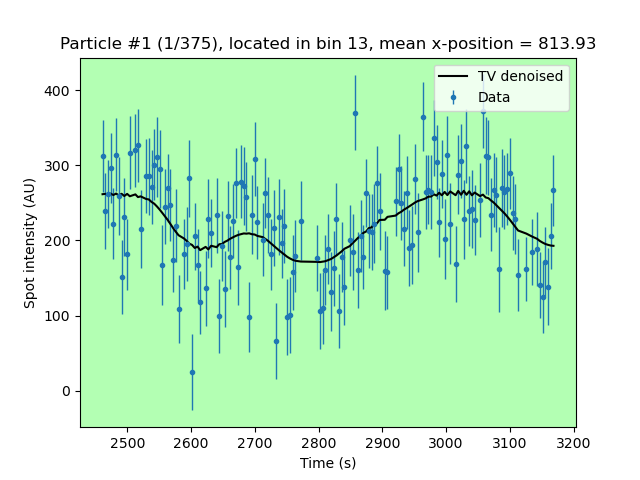

In [23]:
%matplotlib widget
check_particle_fit(binned_particles_fitted)

## Bin Particles and Average Their Rates

In [44]:
def bin_fit_average(binned_particles_fitted):
    '''
    For all the particles in each bin, take the average rate of all the accepted particles.
    '''
    bin_num = binned_particles_fitted['bin'].max()+1
    
    fit_average = [None]*bin_num
    
    for bin in range(bin_num):
        mask = (binned_particles_fitted["bin"] == bin) & (binned_particles_fitted['approval_status'] == 1)
        masked_data = binned_particles_fitted[mask]
        fit_rates = masked_data['fit_rate']
        average_rate = np.mean(fit_rates)
        fit_average[bin] = average_rate

    return np.array(fit_average)

In [45]:
fit_average = bin_fit_average(binned_particles_fitted)
fit_average = fit_average*60 # multiply by 60 so that the unit is AU/min instead of AU/s
fit_average

array([         nan,          nan,  51.39552684,          nan,
        90.76632977,  76.35886468, 278.18567112, 192.75527774,
       360.56552729, 191.98303009, 195.40185509, 134.83748793,
       166.50420136, 106.04517485, 141.04898956])

Text(13, -30, 'A')

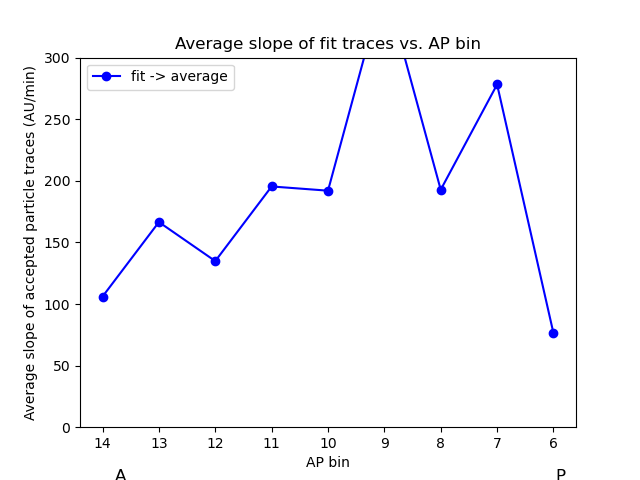

In [46]:
start_bin = 5
end_bin = 14

plt.figure()
plt.plot(np.array(range(start_bin, end_bin))+1, fit_average[start_bin:end_bin], '-o', label='fit -> average', color='blue')
plt.xlabel('AP bin')
plt.ylabel('Average slope of accepted particle traces (AU/min)')
plt.ylim(0,300)
plt.title('Average slope of fit traces vs. AP bin')
plt.legend()
plt.gca().invert_xaxis()

# Adding "P" on the left end of the x-axis
plt.annotate('P', xy=(start_bin+1, 0), xycoords='data', xytext=(start_bin, -30),
             textcoords='offset points', ha='center', va='top', fontsize=12)

# Adding "A" on the right end of the x-axis
plt.annotate('A', xy=(end_bin, 0), xycoords='data', xytext=(end_bin-1, -30),
             textcoords='offset points', ha='center', va='top', fontsize=12)

## Test of Linear Fit in 

In [1]:
# a function that generates a linear fit to the specified range of the plot

def linear_fit_in_range(x, y, x_range=[min(x),max(x)]):
    # Convert lists to numpy arrays
    x_data = np.array(list(x))
    y_data = np.array(list(y))
    
    # Mask to select data within the specified x range
    mask = (x_data >= x_range[0]) & (x_data <= x_range[1])
    x_selected = x_data[mask]
    y_selected = y_data[mask]
    
    # Perform linear fit
    fit_params = np.polyfit(x_selected, y_selected, 1)
    slope, intercept = fit_params
    
    return slope, intercept, x_selected

NameError: name 'x' is not defined

133.54663065491079


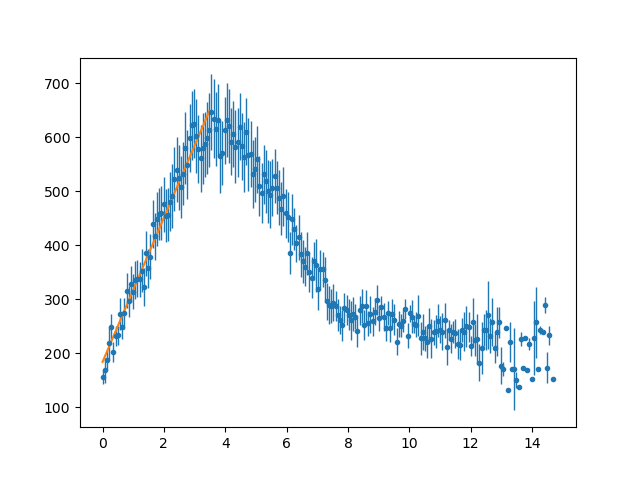

In [401]:
bin = 8
time_res_min = 4.25939/60
x = np.array(intensity_by_frame[bin]['frame'])*time_res_min
y = np.array(intensity_by_frame[bin]['average_intensity'])
y_err = np.array(intensity_by_frame[bin]['std_err_intensity'])

plt.figure()
plt.errorbar(x, y, yerr=y_err, fmt=".", elinewidth=1,)
k, b, x_lim = linear_fit_in_range(x, y, x_range=[0, 3.5])
plt.plot(x_lim, k*x_lim+b)
print(k)